# Jacobian-based Saliency Map Attack (JSMA)

Papernot et al. designed an efficient saliency adversarial map, called Jacobian-based Saliency Map Attack [The Limitations of Deep Learning in Adversarial Settings](https://arxiv.org/pdf/1511.07528.pdf). They first computed Jacobian matrix of given sample x, which is given by:

∂F(x) 􏰅∂Fj(x)􏰆 JF(x)= ∂x = ∂x .

F denotes the second-to-last layer (logits). The input features of x makes most significant changes to the output.

A small perturbation was designed to successfully induce large output variations so that change in a small portion
of features could fool the neural network.

Two adversarial saliency maps ared defined to select the feature/pixel to be crafted in each iteration. They achieved 97% adversarial success rate by modifying only 4.02% input features per sample. However, this method runs very slow due to its significant computational cost.

In [1]:
%pylab inline

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

Populating the interactive namespace from numpy and matplotlib


In [2]:
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

CUDA Available:  False


In [3]:
nn = models.inception_v3(pretrained=True).to(device)
# nn = models.resnet50(pretrained=True).to(device)
nn.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [4]:
!curl https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt --output data/imagenet_classes.txt
    
with open("data/imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10472  100 10472    0     0  44913      0 --:--:-- --:--:-- --:--:-- 45729


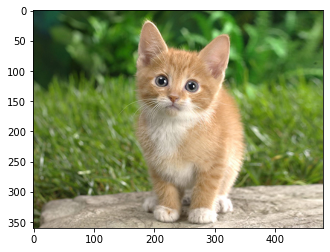

In [5]:
img = Image.open("/Volumes/artemis/library/datasets/cat.jpg")
plt.imshow(img)

In [6]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [7]:
input_tensor = preprocess(img).unsqueeze(0)

In [8]:
def predict(model, x):
    output = model(x)
    pred = F.softmax(output, dim=1)
    _, indicies = torch.topk(pred, k=1)
    for i in indicies.data.numpy().ravel():
        cost = pred.data[0][i]
        print("Class ID: {} | Label: {} | Accuracy: {}%".format(str(i), classes[i], 100 * cost))

In [9]:
predict(nn, input_tensor)

Class ID: 282 | Label: tiger cat | Accuracy: 93.17092895507812%


In [10]:
def get_label(model, x):
    output = model(x)
    return torch.argmax(output, dim=1)

In [11]:
def calc_gradient(model, x, y):
    output = model(x)
    gradients = torch.sum(output[:, y]).backward()
    return x.grad

In [12]:
def compute_jacobian(model, x, y, count):
    jacobian = torch.stack([calc_gradient(model, x, yadv) for yadv in range(count)])
    grads = jacobian.view((jacobian.shape[0], jacobian.shape[1], -1))
    grads_target = grads[y, range(len(y)), :]
    grads_other = grads.sum(dim=0) - grads_target
    return grads_target, grads_other

In [13]:
image = input_tensor.clone()
label = get_label(nn, image)

In [14]:
target = torch.tensor(859).unsqueeze(0)   # Specified Target

In [15]:
image, target = image.to(device), target.to(device)
image.requires_grad = True

grads_target, grads_other = compute_jacobian(nn, image, target, len(classes))

In [16]:
denorm = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
                             transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])])

In [17]:
def postprocess(data):
    image = denorm(data.squeeze()).detach().numpy()
    image = np.rollaxis(image, 0, 3)
    return image

In [18]:
attack_image = postprocess(image)

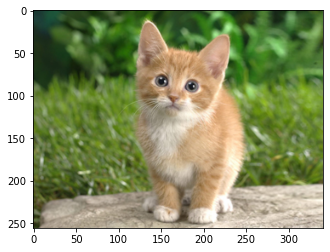

In [19]:
plt.imshow(attack_image)

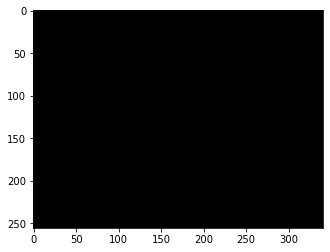

In [20]:
diff = (attack_image - postprocess(input_tensor))
plt.imshow(diff)